In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import warnings

from typing import List

warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 0. Некоторые полезные штуки

In [3]:
def isnan(value):
    return value is None or value != value

In [4]:
def analyze(series, categorical: bool = None):

  if isinstance(series, pd.DataFrame):
    series = series.iloc[:, 0]

  series_unique = sorted(series.unique())

  if categorical is None:
    categorical = len(series_unique) < 30


  max_len = 10

  print(
    f"unique: {len(series_unique)}",
    f"empty: {sum([isnan(el) for el in series])}",
    f"filled: {sum([not isnan(el) for el in series])},",
    f"values: {list(series_unique[:max_len]) + [] if len(series_unique) < max_len else ['...']}" if categorical else ""
  )
  if categorical:
    for val in series_unique[:max_len]:
      if isnan(val):
        print(f"{val} - {sum(series.isna())} times")
      else:
        print(f"{val} - {sum(series == val)} times")
    if len(series_unique) < 30:
      series.hist(xrot=-30)
  else:
    print(f"min: {series.min()}, mean: {series.mean()}, max: {series.max()}, std: {series.std()}")
    series.hist()
  plt.show()

# 1. Загружаем данные

In [5]:

filename = 'output.xlsx'


In [6]:
covid_contracts_positions_with_lot = pd.read_excel(filename)
print(list(covid_contracts_positions_with_lot.columns))
covid_contracts_positions_with_lot

['Unnamed: 0', 'contract_guid', 'contract_registration_number', 'notice_not_placed_by_fz223p5s4', 'contract_extension', 'contract_prolongation', 'customer_appeale_or_needs_approval', 'customer_approval_or_antimonopoly_descision_date', 'contract_plan_position_guid', 'contract_create_date_time', 'contract_customer_inn', 'contract_placer_inn', 'contract_detached_org_inn', 'contract_publication_date', 'contract_publication_date.1', 'emergency', 'provider', 'provider_code', 'contract_reg_number', 'contract_date', 'digital_purchase', 'purchase_notice_info_guid', 'purchase_notice_info_number', 'lot_guid', 'subject_contract', 'purchase_type_code', 'contract_price', 'contract_rub_price', 'contract_currency_code', 'contract_start_execution_date', 'contract_end_execution_date', 'region_name', 'notice_lot_initial_sum', 'notice_lot_starting_contract_price_rub', 'notice_lot_currency_code', 'notice_lot_commodity_price', 'notice_lot_commodity_price_rub', 'notice_lot_max_contract_price', 'notice_lot_ma

,Unnamed: 0,contract_guid,contract_registration_number,notice_not_placed_by_fz223p5s4,contract_extension,contract_prolongation,customer_appeale_or_needs_approval,customer_approval_or_antimonopoly_descision_date,contract_plan_position_guid,contract_create_date_time,contract_customer_inn,contract_placer_inn,contract_detached_org_inn,contract_publication_date,contract_publication_date.1,emergency,provider,provider_code,contract_reg_number,contract_date,digital_purchase,purchase_notice_info_guid,purchase_notice_info_number,lot_guid,subject_contract,purchase_type_code,contract_price,contract_rub_price,contract_currency_code,contract_start_execution_date,contract_end_execution_date,region_name,notice_lot_initial_sum,notice_lot_starting_contract_price_rub,notice_lot_currency_code,notice_lot_commodity_price,notice_lot_commodity_price_rub,notice_lot_max_contract_price,notice_lot_max_contract_price_rub,contract_is_complete,contract_position_name,position_okpd2_code,position_okpd2_name,position_country_code,position_producer_country,position_impossible_to_determine_attr,position_okei_code,position_okei_name,position_qty,position_unit_price,position_rub_unit_price,position_currency_code,contracts_for_lot,notice_customer_inn,notice_placer_inn,notice_detached_org_inn,contract_positions_count,supplier_inn,supplier_name,supplier_ogrn,supplier_type
0,0,00026a57-3035-45cd-9a0b-598d5b233a6b,57017000450210000030001,0,0,0,0,NaN,NaN,2021-01-12 02:56:07,7017000450,7017000450,NaN,2021-01-12 03:47:29,P,0.0,0,NaN,57017000450210000030000,2021-01-11,1,602e9024-21e9-4da1-88fe-e597cf556b70,32009825416,706d8038-0c86-437b-b260-cb592f2fc8f9,Поставка перчаток медицинских для нужд ОГАУЗ «Поликлиника № 10»,40000,550800.0,550800.0,RUB,2021-01-11,2021-06-29,Tomskaya_obl,550800.0,NaN,RUB,NaN,NaN,NaN,NaN,1.0,Перчатки,22.19.60.111,Перчатки хирургические резиновые,NaN,NaN,0,715,Пара (2 шт.),4000.0,26.0,NaN,RUB,1,7017000450,7017000450,NaN,8,NaN,NaN,NaN,NaN
1,1,00026a57-3035-45cd-9a0b-598d5b233a6b,57017000450210000030001,0,0,0,0,NaN,NaN,2021-01-12 02:56:07,7017000450,7017000450,NaN,2021-01-12 03:47:29,P,0.0,0,NaN,57017000450210000030000,2021-01-11,1,602e9024-21e9-4da1-88fe-e597cf556b70,32009825416,706d8038-0c86-437b-b260-cb592f2fc8f9,Поставка перчаток медицинских для нужд ОГАУЗ «Поликлиника № 10»,40000,550800.0,550800.0,RUB,2021-01-11,2021-06-29,Tomskaya_obl,550800.0,NaN,RUB,NaN,NaN,NaN,NaN,1.0,Перчатки,22.19.60.111,Перчатки хирургические резиновые,NaN,NaN,0,715,Пара (2 шт.),5000.0,26.0,NaN,RUB,1,7017000450,7017000450,NaN,8,NaN,NaN,NaN,NaN
2,2,00026a57-3035-45cd-9a0b-598d5b233a6b,57017000450210000030001,0,0,0,0,NaN,NaN,2021-01-12 02:56:07,7017000450,7017000450,NaN,2021-01-12 03:47:29,P,0.0,0,NaN,57017000450210000030000,2021-01-11,1,602e9024-21e9-4da1-88fe-e597cf556b70,32009825416,706d8038-0c86-437b-b260-cb592f2fc8f9,Поставка перчаток медицинских для нужд ОГАУЗ «Поликлиника № 10»,40000,550800.0,550800.0,RUB,2021-01-11,2021-06-29,Tomskaya_obl,550800.0,NaN,RUB,NaN,NaN,NaN,NaN,1.0,Перчатки,22.19.60.111,Перчатки хирургические резиновые,NaN,NaN,0,715,Пара (2 шт.),1000.0,28.0,NaN,RUB,1,7017000450,7017000450,NaN,8,NaN,NaN,NaN,NaN
3,3,00026a57-3035-45cd-9a0b-598d5b233a6b,57017000450210000030001,0,0,0,0,NaN,NaN,2021-01-12 02:56:07,7017000450,7017000450,NaN,2021-01-12 03:47:29,P,0.0,0,NaN,57017000450210000030000,2021-01-11,1,602e9024-21e9-4da1-88fe-e597cf556b70,32009825416,706d8038-0c86-437b-b260-cb592f2fc8f9,Поставка перчаток медицинских для нужд ОГАУЗ «Поликлиника № 10»,40000,550800.0,550800.0,RUB,2021-01-11,2021-06-29,Tomskaya_obl,550800.0,NaN,RUB,NaN,NaN,NaN,NaN,1.0,Перчатки,22.19.60.111,Перчатки хирургические резиновые,NaN,NaN,0,715,Пара (2 шт.),100.0,54.0,NaN,RUB,1,7017000450,7017000450,NaN,8,NaN,NaN,NaN,NaN
4,4,00026a57-3035-45cd-9a0b-598d5b233a6b,57017000450210000030001,0,0,0,0,NaN,NaN,2021-01-12 02:56:07,7017000450,7017000450,NaN,2021-01-12 03:47:29,P,0.0,0,NaN,57017000450210000030000,2021-01-11,1,602e9024-21e9-4da1-88fe-e597cf556b70,32009825416,706d8038-0c86-437b-b260-cb

# 2. Предобработка данных

### Выбор признаков

#### оставляем только необходимые в дальнейшем признаки

In [7]:
features = [
    'contract_guid',
    'contract_is_complete',
    'contract_extension',  # [0, 1] Договором предусмотрена возможность продления срока действия договора после его окончания
    'purchase_type_code',  # ['400002', '400001', '300002', '300001', '110112', '120121', '110111'] Код признака закупки в электронном виде
    'notice_lot_max_contract_price',
    'notice_lot_initial_sum',
    'region_name',  # ['Sankt-Peterburg', 'Moskva', 'Krasnodarskii_krai', 'Moskovskaya_obl', 'Leningradskaya_obl', 'Primorskii_krai']
    'notice_lot_currency_code',  # ['RUB', 'EUR', 'CZK', 'USD', 'GBP', 'JPY', 'MNT']
    'position_okpd2_code',
    'position_okpd2_name',
    'position_impossible_to_determine_attr',  # [0, 1] Невозможно определить количество (объем)
    'supplier_inn', # ИНН поставщика
    'supplier_type', # Физик / Юрик
    'contract_placer_inn', # ИНН заказчика
    'contract_rub_price', # сумма контрактов в валюте переведенная в рубли
    'contract_price', # сумма рублевых контрактов
    'contract_start_execution_date', # Дата начала контракта
    'contract_end_execution_date', # Дата завершения контракта
    'notice_lot_currency_code',
    'contracts_for_lot', # Договоров на лот
    'contract_positions_count', # Позиций в договоре
    'lot_guid'

]

df = covid_contracts_positions_with_lot[features]
df = df.loc[:,~df.columns.duplicated()]
df.reset_index(drop=True, inplace=True)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,position_okpd2_code,position_okpd2_name,position_impossible_to_determine_attr,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid
0,00026a57-3035-45cd-9a0b-598d5b233a6b,1.0,0,40000,NaN,550800.0,Tomskaya_obl,RUB,22.19.60.111,Перчатки хирургические резиновые,0,NaN,NaN,7017000450,550800.0,550800.0,2021-01-11,2021-06-29,1,8,706d8038-0c86-437b-b260-cb592f2fc8f9
1,00026a57-3035-45cd-9a0b-598d5b233a6b,1.0,0,40000,NaN,550800.0,Tomskaya_obl,RUB,22.19.60.111,Перчатки хирургические резиновые,0,NaN,NaN,7017000450,550800.0,550800.0,2021-01-11,2021-06-29,1,8,706d8038-0c86-437b-b260-cb592f2fc8f9
2,00026a57-3035-45cd-9a0b-598d5b233a6b,1.0,0,40000,NaN,550800.0,Tomskaya_obl,RUB,22.19.60.111,Перчатки хирургические резиновые,0,NaN,NaN,7017000450,550800.0,550800.0,2021-01-11,2021-06-29,1,8,706d8038-0c86-437b-b260-cb592f2fc8f9
3,00026a57-3035-45cd-9a0b-598d5b233a6b,1.0,0,40000,NaN,550800.0,Tomskaya_obl,RUB,22.19.60.111,Перчатки хирургические резиновые,0,NaN,NaN,7017000450,550800.0,550800.0,2021-01-11,2021-06-29,1,8,706d8038-0c86-437b-b260-cb592f2fc8f9
4,00026a57-3035-45cd-9a0b-598d5b233a6b,1.0,0,40000,NaN,550800.0,Tomskaya_obl,RUB,22.19.60.111,Перчатки хирургические резиновые,0,NaN,NaN,7017000450,550800.0,550800.0,2021-01-11,2021-06-29,1,8,706d8038-0c86-437b-b260-cb592f2fc8f9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87908,fff8e8de-86d6-413a-b072-3dc7c247fff0,NaN,1,40000,NaN,49270.5,Kemerowskaya_obl,RUB,21.20.10,Препараты лекарственные,0,NaN,NaN,4223127015,NaN,30937.2,2021-08-08,2021-12-30,1,6,9bbadbe8-c1f6-4c11-a759-60f340769ab2
87909,fff8e8de-86d6-413a-b072-3dc7c247fff0,NaN,1,40000,NaN,49270.5,Kemerowskaya_obl,RUB,21.20.10,Препараты лекарственные,0,NaN,NaN,4223127015,NaN,30937.2,2021-08-08,2021-12-30,1,6,9bbadbe8-c1f6-4c11-a759-60f340769ab2
87910,fff8e8de-86d6-413a-b072-3dc7c247fff0,NaN,1,40000,NaN,49270.5,Kemerowskaya_obl,RUB,21.20.10,Препараты лекарственные,0,NaN,NaN,4223127015,NaN,30937.2,2021-08-08,2021-12-30,1,6,9bbadbe8-c1f6-4c11-a759-60f340769ab2
87911,fffb9623-244a-4c27-b1c7-4518ab6412bd,1.0,0,40000,NaN,600600.0,Saha_Jakutiya_Resp,RUB,21.20.10,Препараты лекарственные,0,NaN,NaN,1431004812,NaN,600600.0,2021-07-06,2021-12-30,1,1,89d200ae-e338-463b-89b3-0cf5955eee3c


#### Убираем тех, у кого нет ИНН поставщика

In [8]:
df.dropna(subset=['supplier_inn'], inplace=True)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,position_okpd2_code,position_okpd2_name,position_impossible_to_determine_attr,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid
60,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,26.51,"Оборудование для измерения, испытаний и навигации",0,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea
64,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,32.50.50.000,"Изделия медицинские, в том числе хирургические, прочие",0,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d
104,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,14.19.32.120,Одежда из нетканых материалов,0,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc
116,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,20.20.14.000,Средства дезинфекционные,0,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508
2429,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,21.20.10.158,Антисептики и дезинфицирующие препараты,0,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87666,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,20.59.52.199,"Реагенты сложные диагностические или лабораторные прочие, не включенные в другие группировки",0,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772
87667,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,22.29.29.190,"Изделия пластмассовые прочие, не включенные в другие группировки",0,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772
87800,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,85.42.19.000,Услуги по дополнительному профессиональному образованию прочие,0,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f
87802,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,20.20.14.000,Средства дезинфекционные,1,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c


#### Определяем стоимость договора в рублях и начальную цену договора

In [9]:
df['real_rub_price'] = df.apply(
    lambda row: row['contract_rub_price'] if not isnan(row['contract_rub_price']) else row['contract_price'],
    axis=1
)

df['real_initial_sum'] = df.apply(
    lambda row: row['notice_lot_max_contract_price'] if not isnan(row['notice_lot_max_contract_price']) else row['notice_lot_initial_sum'],
    axis=1
)

#### Убираем строки где нет начальной цены

In [10]:
df.dropna(subset=['real_initial_sum'], inplace=True)
df.drop(df[df['real_initial_sum'] == 0].index, inplace=True)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,position_okpd2_code,position_okpd2_name,position_impossible_to_determine_attr,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum
60,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,26.51,"Оборудование для измерения, испытаний и навигации",0,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00
64,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,32.50.50.000,"Изделия медицинские, в том числе хирургические, прочие",0,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76
104,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,14.19.32.120,Одежда из нетканых материалов,0,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00
116,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,20.20.14.000,Средства дезинфекционные,0,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00
2429,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,21.20.10.158,Антисептики и дезинфицирующие препараты,0,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87666,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,20.59.52.199,"Реагенты сложные диагностические или лабораторные прочие, не включенные в другие группировки",0,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52
87667,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,22.29.29.190,"Изделия пластмассовые прочие, не включенные в другие группировки",0,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52
87800,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,85.42.19.000,Услуги по дополнительному профессиональному образованию прочие,0,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60
87802,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,20.20.14.000,Средства дезинфекционные,1,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00


#### Приводим описание okpd2 к нижнему регистру

In [11]:
df['position_okpd2_name'] = df.apply(
    lambda row: str(row['position_okpd2_name']).lower(), axis=1
)

#### Определяем вид *ПОЗИЦИИ* по окпд2


In [12]:
def category(row):
  if row['position_okpd2_code'][:2] in ['37', '38', '61', '62', '80', '81', '82', '84', '95','96']:
      if 'услуги' in row['position_okpd2_name']:# это условие собирает ок
          return 'ХозУслуги'
      else:
          return 'МедУслуги'# ok
  elif row['position_okpd2_code'][:2] in ['05', '08', '16', '24', '25', '36', '41', '42', '43', '47', '71']:
      if ('перевооруж' in row['position_okpd2_name']
          or 'ремонт' in row['position_okpd2_name']
          or 'замена' in row['position_okpd2_name']
          or 'работы' in row['position_okpd2_name']) and ('элект' in row['position_okpd2_name'] or 'отопл' in row['position_okpd2_name']
                                                          or  'водопров' in row['position_okpd2_name'] or  'газов' in row['position_okpd2_name']
                                                           or 'рельс' in row['position_okpd2_name']):
          return 'ХозУслуги'#ok
      elif ('перевооруж' in row['position_okpd2_name']
          or 'ремонт' in row['position_okpd2_name']
          or 'замена' in row['position_okpd2_name']
          or 'работы' in row['position_okpd2_name']) and not ('элект' in row['position_okpd2_name'] or 'отопл' in row['position_okpd2_name']
                                                          or  'водопров' in row['position_okpd2_name'] or  'газов' in row['position_okpd2_name']
                                                           or 'рельс' in row['position_okpd2_name']):
          return 'Строительство'#ok
      elif ('емкости из' in row['position_okpd2_name'] or 'ферросплавы' in row['position_okpd2_name'] or 'винты' in row['position_okpd2_name']
             or 'котлы' in row['position_okpd2_name']  or 'проволок' in row['position_okpd2_name']  or 'труб' in row['position_okpd2_name']
            or 'электрод' in row['position_okpd2_name'] or 'труб' in row['position_okpd2_name']
            ):
        return 'ХозМат'#ok

      else:
          return 'ХозУслуги'#ok
  elif row['position_okpd2_code'][:2] in ['13', '14', '15', '20', '21', '22' , '23']:
      if ('медицин' in row['position_okpd2_name'] or 'маск' in row['position_okpd2_name'] or 'комбинез' in row['position_okpd2_name']
    or 'анальг' in row['position_okpd2_name'] or 'анест' in row['position_okpd2_name'] or 'антибиот' in row['position_okpd2_name'] or 'антисепт' in row['position_okpd2_name']
    or 'вазодил' in row['position_okpd2_name'] or 'стероид' in row['position_okpd2_name'] or 'гормон' in row['position_okpd2_name'] or 'добавки' in row['position_okpd2_name']
    or 'имуно' in row['position_okpd2_name'] or 'кислород' in row['position_okpd2_name'] or 'микроорганизм' in row['position_okpd2_name'] or 'санитарно' in row['position_okpd2_name']
    or 'санитарно' in row['position_okpd2_name'] or 'санитарно' in row['position_okpd2_name'] or 'санитарно' in row['position_okpd2_name'] or 'санитарно' in row['position_okpd2_name']
    or 'пеницил' in row['position_okpd2_name'] or 'хирург' in row['position_okpd2_name'] or 'антианемич' in row['position_okpd2_name'] or 'антибактериал' in row['position_okpd2_name']
    or 'гематолог' in row['position_okpd2_name'] or 'препарат' in row['position_okpd2_name'] or 'налептик' in row['position_okpd2_name'] or 'плазмо' in row['position_okpd2_name']
    or 'нуклеин' in row['position_okpd2_name'] or 'диагност' in row['position_okpd2_name'] or 'спирт' in row['position_okpd2_name'] or 'дезинфекц' in row['position_okpd2_name']
    or 'средства защиты' in row['position_okpd2_name'] or 'фармацевт' in row['position_okpd2_name'] or 'сыворотк' in row['position_okpd2_name'] or 'цефалоспор' in row['position_okpd2_name']
    or 'эфир' in row['position_okpd2_name'] or 'антикоаг' in row['position_okpd2_name'] or 'контраст' in row['position_okpd2_name'] or 'химич' in row['position_okpd2_name']
    or 'иммун' in row['position_okpd2_name'] or 'индикатор' in row['position_okpd2_name']):
          return 'МедМат'#ok
      else:
          return 'ХозМат'#ok
  elif row['position_okpd2_code'][:2] in ['26', '27', '28', '32']:
      if ('протез' in row['position_okpd2_name'] or 'респиратор' in row['position_okpd2_name'] or 'средства защит' in row['position_okpd2_name']
          or 'средства индив' in row['position_okpd2_name'] or 'термометр' in row['position_okpd2_name'] or 'шприц' in row['position_okpd2_name']):
        return 'МедМат'#ok
      elif ('специального назн' in row['position_okpd2_name'] or 'рентген' in row['position_okpd2_name'] or 'медиц' in row['position_okpd2_name']
            or 'терапевт' in row['position_okpd2_name'] or 'дыхател' in row['position_okpd2_name'] or 'фильтров' in row['position_okpd2_name']
             or 'центрифуг' in row['position_okpd2_name'] or 'кардио' in row['position_okpd2_name'] or 'диагност' in row['position_okpd2_name']
            or 'ультрафиолет' in row['position_okpd2_name'] or 'терапии' in row['position_okpd2_name']):
          return 'МедОбор'#ok
      elif ('аппарат' in row['position_okpd2_name'] or 'компьютер' in row['position_okpd2_name'] or 'оборуд' in row['position_okpd2_name']
            or 'насос' in row['position_okpd2_name'] or 'трансформатор' in row['position_okpd2_name'] or 'устройств' in row['position_okpd2_name']
            or 'экспоном' in row['position_okpd2_name'] or 'редуктор' in row['position_okpd2_name'] or 'средств' in row['position_okpd2_name']
            or 'установк' in row['position_okpd2_name'] or 'машин' in row['position_okpd2_name']):
        return 'ХозОбор'#ok
      else:
          return 'ХозМат'#ok
  elif row['position_okpd2_code'][:2] in ['01' , '10' , '11', '46', '56']:
    if ('машин' in row['position_okpd2_name']):
      return 'ХозОбор'#ok
    elif ('водопровод' in row['position_okpd2_name']):
      return 'ХозМат'#ok
    elif ('фармац' in row['position_okpd2_name']):
      return 'МедМат'#ok
    else:
      return 'Еда'   #ok
  elif row['position_okpd2_code'][:2] in  ['33', '52', '65', '72', '86']:
    if ('больн' in row['position_okpd2_name'] or 'медиц' in row['position_okpd2_name'] or 'врач' in row['position_okpd2_name'] ):
          return 'МедУслуги'#ok
    else:
      return 'ХозУслуги'#ok
  elif row['position_okpd2_code'][:2] in ['19', '29', '30', '45', '49', '51']:

    return 'Другое'

  return 'Другое'


df['position_category'] = df.apply(lambda row: category(row), axis=1)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,position_okpd2_code,position_okpd2_name,position_impossible_to_determine_attr,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category
60,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,26.51,"оборудование для измерения, испытаний и навигации",0,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,ХозОбор
64,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,32.50.50.000,"изделия медицинские, в том числе хирургические, прочие",0,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,МедОбор
104,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,14.19.32.120,одежда из нетканых материалов,0,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,ХозМат
116,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,20.20.14.000,средства дезинфекционные,0,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,МедМат
2429,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,21.20.10.158,антисептики и дезинфицирующие препараты,0,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,МедМат
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87666,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,20.59.52.199,"реагенты сложные диагностические или лабораторные прочие, не включенные в другие группировки",0,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,МедМат
87667,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,22.29.29.190,"изделия пластмассовые прочие, не включенные в другие группировки",0,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,ХозМат
87800,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,85.42.19.000,услуги по дополнительному профессиональному образованию прочие,0,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,Другое
87802,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,20.20.14.000,средства дезинфекционные,1,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,МедМат


#### Определяем вид *ДОГОВОРА* по позициям

##### Объединяем все встречающиеся типы позиций договора в список

In [13]:
contract_columns = df.columns.to_list()

contract_columns.remove('position_okpd2_code')
contract_columns.remove('position_okpd2_name')
contract_columns.remove('position_category')
contract_columns.remove('position_impossible_to_determine_attr')
contract_columns

['contract_guid',
 'contract_is_complete',
 'contract_extension',
 'purchase_type_code',
 'notice_lot_max_contract_price',
 'notice_lot_initial_sum',
 'region_name',
 'notice_lot_currency_code',
 'supplier_inn',
 'supplier_type',
 'contract_placer_inn',
 'contract_rub_price',
 'contract_price',
 'contract_start_execution_date',
 'contract_end_execution_date',
 'contracts_for_lot',
 'contract_positions_count',
 'lot_guid',
 'real_rub_price',
 'real_initial_sum']

In [14]:
df = df.groupby(contract_columns, dropna=False)['position_category'].apply(list).reset_index()
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор]
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор]
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат]
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат]
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2944,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]"
2945,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]"
2946,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое]
2947,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат]


##### Выбираем в кочестве типа договора самый частый тип позиции
при этом, если самая частая позиция - Другое и есть что-то ещё, отбрасываем категорию другое

In [15]:
def get_most_frequent_category(category_okpd: List[str]) -> str:
    category_dict = {}
    for _category in category_okpd:
        category_dict[_category] = category_dict.get(_category, 0) + 1

    most_frequent_category = ''
    _max_count = 0
    _items_count = len(category_dict)
    for _category, _count in category_dict.items():
        if _items_count != 1 and _category == 'Другое':
            continue
        if _count > _max_count:
            most_frequent_category = _category
            _max_count = _count
    return most_frequent_category

In [16]:
df['contract_category'] = df['position_category'].map(get_most_frequent_category)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2944,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги
2945,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат
2946,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое
2947,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат


unique: 9 empty: 0 filled: 2949, values: ['Другое', 'Еда', 'МедМат', 'МедОбор', 'МедУслуги', 'Строительство', 'ХозМат', 'ХозОбор', 'ХозУслуги']
Другое - 136 times
Еда - 58 times
МедМат - 1130 times
МедОбор - 291 times
МедУслуги - 230 times
Строительство - 137 times
ХозМат - 372 times
ХозОбор - 57 times
ХозУслуги - 538 times


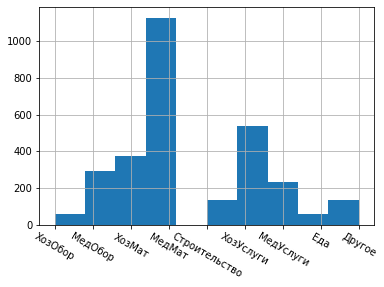

In [17]:
analyze(df['contract_category'], categorical=True)

unique: 2 empty: 0 filled: 2949, values: [30000, 40000]
30000 - 858 times
40000 - 2091 times


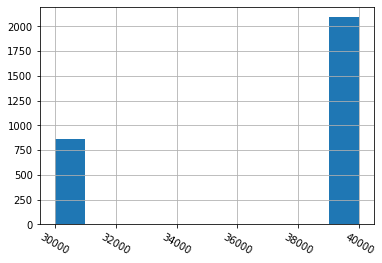

In [18]:
analyze(df['purchase_type_code'], categorical=True)

# 3. Считаем новые признаки

### Экономия по лоту

In [19]:
df[df['contracts_for_lot'] > 1]

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category


Существуют лоты, на которые было заключено более одного договора

##### Абсолютная экономия по лоту

unique: 452 empty: 0 filled: 2949, 
min: -29620000.0, mean: 88535.37283825024, max: 39514475.95000005, std: 1478687.3610156311


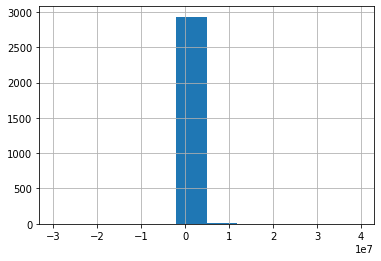

In [20]:
df['economy'] = df.apply(
    lambda row, df_tmp: row['real_initial_sum'] - df_tmp[df_tmp["lot_guid"] == row["lot_guid"]]["real_rub_price"].sum(),
    args=[df], axis=1
)

analyze(df['economy'], categorical=False)

##### Относительная

unique: 442 empty: 0 filled: 2949, 
min: -86.06770029673591, mean: -0.11283026522463493, max: 1.0, std: 3.317683984328736


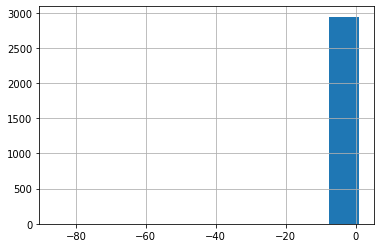

In [21]:
df['economy_percent'] = df.apply(
    lambda row: row['economy'] / row['real_initial_sum'],
    axis=1
)

analyze(df['economy_percent'], categorical=False)

In [22]:
df[df['economy'] < 0]

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent
69,061f80c4-fb14-477a-b884-af2f7f16187b,1.0,0,40000,NaN,245435.40,Ulianovskaya_obl,RUB,7.317002e+09,Юридическое лицо,7328014430,NaN,269978.94,2020-10-14,2020-12-30,1,1,f816091a-e8c7-4989-9e7c-c8a195ac60d1,269978.94,245435.40,[Другое],Другое,-24543.54,-0.100000
81,070fc19f-3668-473e-859b-aef4041cb498,NaN,0,40000,NaN,2700368.55,Kurskaya_obl,RUB,4.634010e+09,Юридическое лицо,4632060153,NaN,4074370.90,2020-03-19,2021-03-19,1,1,9eacd8a0-9d9f-421e-9651-d2784e3a7e92,4074370.90,2700368.55,[ХозУслуги],ХозУслуги,-1374002.35,-0.508820
160,0e086a12-60c8-4170-b0fa-024dad47eed7,1.0,0,40000,NaN,11160000.00,Saha_Jakutiya_Resp,RUB,1.435149e+09,Юридическое лицо,1435167374,NaN,13392000.00,2020-04-19,2020-04-29,1,1,db5e7689-16a9-4b7f-a61b-cd0f472c8fd1,13392000.00,11160000.00,[МедМат],МедМат,-2232000.00,-0.200000
177,0f1283d4-ff04-4e59-8e5d-457ad0b519ff,1.0,0,30000,NaN,700700.00,Sankt-Peterburg,RUB,7.813276e+09,Юридическое лицо,7830001028,NaN,840840.00,2020-11-19,2021-01-29,1,1,10da16ad-61ad-49f6-a9de-b16bb8b75ef3,840840.00,700700.00,[ХозУслуги],ХозУслуги,-140140.00,-0.200000
210,12100447-4e42-2020-0000-000000001475,1.0,0,40000,NaN,4074803.25,Jamalo-Nenetckii_AO,RUB,1.435243e+09,Юридическое лицо,8905026850,7020805.75,7020805.75,2020-05-05,2020-06-09,1,1,5109cfa2-149c-1eda-a2bf-ac7494a55a1d,7020805.75,4074803.25,[ХозУслуги],ХозУслуги,-2946002.50,-0.722980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2743,edfa1e05-ce68-4821-be11-ccc1e457905a,1.0,0,40000,NaN,384096.00,Lipetckaya_obl,RUB,7.718625e+09,Юридическое лицо,4826007416,NaN,384096.82,NaN,NaN,1,1,426c37d3-4476-40f5-99eb-1fd617718273,384096.82,384096.00,[ХозМат],ХозМат,-0.82,-0.000002
2812,f3e1d2ff-35bc-4460-b951-648e928fc390,1.0,0,40000,NaN,924000.00,Moskva,RUB,7.724212e+09,Юридическое лицо,7717022723,1078000.00,1078000.00,2020-12-31,2021-07-30,1,1,33a72d78-b1a3-424d-9546-b066601a06a3,1078000.00,924000.00,[ХозУслуги],ХозУслуги,-154000.00,-0.166667
2869,f7f3dffa-a6e2-4bfb-8f6b-7945f055f242,1.0,0,30000,NaN,118830.00,Tiumenskaya_obl,RUB,7.203462e+09,Юридическое лицо,7224013707,NaN,157250.00,2020-06-07,2020-09-29,1,1,0681948e-e310-4723-adaa-f35f4c7bdf25,157250.00,118830.00,[МедМат],МедМат,-38420.00,-0.323319
2906,fbab9be5-1222-4fda-ab01-95048048f816,1.0,0,40000,NaN,715919.77,Saha_Jakutiya_Resp,RUB,1.431031e+11,Физическое лицо,1435218580,NaN,745536.80,2020-05-31,2020-06-29,1,1,9808bc4e-f70e-4045-be70-fab2bfa4b2d3,745536.80,715919.77,[ХозУслуги],ХозУслуги,-29617.03,-0.041369


In [23]:
df[df['economy_percent'] != 0]

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent
11,00cf4cd6-96ea-438d-9cd2-75ccf02fc0c5,NaN,0,40000,NaN,30833.33,Magadanskaya_obl,RUB,1.101097e+11,Физическое лицо,4909032631,NaN,23127.00,2020-11-22,2021-02-27,1,1,6ae23cf0-2b31-9d69-68ad-09ad20bde981,23127.00,30833.33,[ХозМат],ХозМат,7706.33,0.249935
15,00deaf00-6149-44d2-83c3-64810914139b,0.0,0,40000,NaN,873000.00,Sverdlovskaya_obl,RUB,6.685024e+09,Юридическое лицо,6664033808,NaN,610200.00,2020-05-27,2020-12-30,1,1,2fda9130-0b7e-4beb-8b82-ca5a622a851d,610200.00,873000.00,[МедМат],МедМат,262800.00,0.301031
29,01a23287-797a-4d6e-ae2e-b28507e00448,NaN,0,40000,NaN,3509163.40,Sverdlovskaya_obl,RUB,6.678089e+09,Юридическое лицо,6608001915,NaN,1978413.04,2021-02-15,2022-01-30,1,23,2f43cf71-c809-59ad-98ec-896dd685ecb6,1978413.04,3509163.40,"[ХозМат, МедМат, ХозМат, ХозМат, ХозМат, ХозМат, Другое, ХозМат, ХозМат, Другое, ХозМат, ХозМат, ХозМат, ХозМат, ХозМат, ХозМат, ХозМат, ХозМат, ХозМат, МедМат, Другое, ХозМат, МедМат]",ХозМат,1530750.36,0.436215
31,01d01d05-f18b-4db1-a549-35d785f5be25,1.0,0,40000,NaN,240000.00,Primorskii_krai,RUB,2.536111e+09,Юридическое лицо,2540252341,NaN,234000.00,2021-03-25,2021-12-30,1,1,7045d015-9e8f-12bd-dcea-6d10c4ac5308,234000.00,240000.00,[ХозУслуги],ХозУслуги,6000.00,0.025000
40,02c7f86a-fb99-4ce0-98d0-1496b1a22e2b,NaN,0,40000,NaN,2351546.50,Moskva,RUB,2.741628e+08,Юридическое лицо,7733667750,NaN,2303363.50,2021-12-16,2022-12-30,1,1,568c2bc7-ee93-ddf7-a7cc-166df42e3087,2303363.50,2351546.50,[Еда],Еда,48183.00,0.020490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2932,fe574a2d-e296-438b-a481-1eb0138e4254,1.0,0,40000,NaN,500000.00,Moskva,RUB,7.728709e+09,Юридическое лицо,7729101120,NaN,307500.00,2020-10-25,2020-12-30,1,1,0acdfafd-7b58-46bd-9521-483b3039dbd9,307500.00,500000.00,[МедМат],МедМат,192500.00,0.385000
2935,fe9ca78d-e23a-4d03-b8d7-39660a2c37e4,1.0,0,30000,NaN,150000.00,Hanty-Mansiiskii_AO_Iugra_AO,RUB,8.603158e+09,Юридическое лицо,8602002480,NaN,148200.00,2021-02-17,2021-12-30,1,1,3cf9086d-8141-47e1-ab5e-e5b837ef72d4,148200.00,150000.00,[МедМат],МедМат,1800.00,0.012000
2939,fee2c8ba-178d-4afb-ad14-58223b281445,1.0,0,30000,NaN,378635.00,Brianskaya_obl,RUB,7.727663e+09,Юридическое лицо,3234013184,NaN,359129.10,2021-06-10,2021-08-30,1,1,fdf6afa5-df7e-46c2-ac0b-3455fe5f6d75,359129.10,378635.00,[МедМат],МедМат,19505.90,0.051516
2940,fee6970b-505a-4e7d-bdae-3ebbabb7e723,1.0,0,40000,NaN,1500000.00,Moskva,RUB,7.707300e+09,Юридическое лицо,7729101120,NaN,222615.00,2020-10-19,2020-12-30,1,1,3600b5fa-979b-4926-9694-3b5a4c15afd8,222615.00,1500000.00,[МедМат],МедМат,1277385.00,0.851590


### Считаем признаки для пары поставщик-заказчик

##### % контрактов поставщика у заказчика относительно всех контрактов поставщика

всего договоров у заказчика

In [24]:
df['total_placer_contracts'] = df.apply(
    lambda row, df_tmp: df_tmp[df_tmp["contract_placer_inn"] == row["contract_placer_inn"]].shape[0], args=[df], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,17
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2944,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1
2945,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9
2946,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28
2947,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2


всего договоров заказчика с поставщиком

In [25]:
df['total_placer_with_supplier_contracts'] = df.apply(
    lambda row, df_tmp: df_tmp[df_tmp["contract_placer_inn"] == row["contract_placer_inn"]]
        [df["supplier_inn"] == row["supplier_inn"]].shape[0], args=[df], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4,1
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24,10
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46,11
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,17,12
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2944,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1,1
2945,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9,5
2946,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28,1
2947,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2,2


Процент договоров, которые заказчик заключил с конкретным поставщиком

In [26]:
df['percent_placer_with_supplier_contracts'] = df.apply(
    lambda row: row['total_placer_with_supplier_contracts'] / row['total_placer_contracts'], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4,1,0.250000
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24,10,0.416667
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46,11,0.239130
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,17,12,0.705882
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5,1,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2944,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1,1,1.000000
2945,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9,5,0.555556
2946,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28,1,0.035714
2947,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2,2,1.000000


##### % контрактов заказчика с поставщиком относительно всех контрактов заказчика

Всего договоров у заказчика

In [27]:
df['total_supplier_contracts'] = df.apply(
    lambda row, df_tmp: df_tmp[df_tmp["supplier_inn"] == row["supplier_inn"]].shape[0], args=[df], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4,1,0.250000,1
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24,10,0.416667,27
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46,11,0.239130,11
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,17,12,0.705882,12
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5,1,0.200000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2944,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1,1,1.000000,1
2945,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9,5,0.555556,6
2946,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28,1,0.035714,1
2947,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2,2,1.000000,2


Процент договоров, которые поставщик заключил с конкретным заказчиком

In [28]:
df['percent_supplier_with_placer_contracts'] = df.apply(
    lambda row: row['total_placer_with_supplier_contracts'] / row['total_supplier_contracts'], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts,percent_supplier_with_placer_contracts
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4,1,0.250000,1,1.000000
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24,10,0.416667,27,0.370370
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46,11,0.239130,11,1.000000
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,17,12,0.705882,12,1.000000
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5,1,0.200000,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2944,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1,1,1.000000,1,1.000000
2945,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9,5,0.555556,6,0.833333
2946,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28,1,0.035714,1,1.000000
2947,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2,2,1.000000,2,1.000000


##### максимальное количество позиций в лоте для пары

In [29]:
df['max_contract_positions_placer_supplier'] = df.apply(
    lambda row, df_tmp: df_tmp[df_tmp["contract_placer_inn"] == row["contract_placer_inn"]]
        [df["supplier_inn"] == row["supplier_inn"]]['contract_positions_count'].max(), args=[df], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts,percent_supplier_with_placer_contracts,max_contract_positions_placer_supplier
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4,1,0.250000,1,1.000000,1
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24,10,0.416667,27,0.370370,3
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46,11,0.239130,11,1.000000,4
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,17,12,0.705882,12,1.000000,4
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5,1,0.200000,1,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2944,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1,1,1.000000,1,1.000000,7
2945,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9,5,0.555556,6,0.833333,3
2946,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28,1,0.035714,1,1.000000,1
2947,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2,2,1.000000,2,1.000000,1


##### среднее количество позиций в лоте

In [30]:
df['mean_contract_positions_placer_supplier'] = df.apply(
    lambda row, df_tmp: df_tmp[df_tmp["contract_placer_inn"] == row["contract_placer_inn"]]
        [df["supplier_inn"] == row["supplier_inn"]]['contract_positions_count'].mean(), args=[df], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts,percent_supplier_with_placer_contracts,max_contract_positions_placer_supplier,mean_contract_positions_placer_supplier
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4,1,0.250000,1,1.000000,1,1.000000
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24,10,0.416667,27,0.370370,3,1.600000
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46,11,0.239130,11,1.000000,4,1.272727
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,17,12,0.705882,12,1.000000,4,1.916667
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5,1,0.200000,1,1.000000,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2944,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1,1,1.000000,1,1.000000,7,7.000000
2945,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9,5,0.555556,6,0.833333,3,1.800000
2946,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28,1,0.035714,1,1.000000,1,1.000000
2947,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2,2,1.000000,2,1.000000,1,1.000000


##### общая сумма договоров между заказчиком и поставщиком

In [31]:
df['total_contract_sum_placer_supplier'] = df.apply(
    lambda row, df_tmp: df_tmp[df_tmp["contract_placer_inn"] == row["contract_placer_inn"]]
    [df["supplier_inn"] == row["supplier_inn"]]['real_rub_price'].sum(), args=[df], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts,percent_supplier_with_placer_contracts,max_contract_positions_placer_supplier,mean_contract_positions_placer_supplier,total_contract_sum_placer_supplier
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4,1,0.250000,1,1.000000,1,1.000000,243570.00
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24,10,0.416667,27,0.370370,3,1.600000,5145375.13
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46,11,0.239130,11,1.000000,4,1.272727,4954000.00
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,17,12,0.705882,12,1.000000,4,1.916667,7242190.00
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5,1,0.200000,1,1.000000,1,1.000000,499850.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2944,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1,1,1.000000,1,1.000000,7,7.000000,974997.49
2945,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9,5,0.555556,6,0.833333,3,1.800000,2168562.02
2946,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28,1,0.035714,1,1.000000,1,1.000000,2208918.60
2947,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2,2,1.000000,2,1.000000,1,1.000000,972800.00


##### средняя сумма договоров между заказчиком и поставщиком

In [32]:
df['mean_contract_sum_placer_supplier'] = df.apply(
    lambda row, df_tmp: df_tmp[df_tmp["contract_placer_inn"] == row["contract_placer_inn"]]
    [df["supplier_inn"] == row["supplier_inn"]]['real_rub_price'].mean(), args=[df], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts,percent_supplier_with_placer_contracts,max_contract_positions_placer_supplier,mean_contract_positions_placer_supplier,total_contract_sum_placer_supplier,mean_contract_sum_placer_supplier
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4,1,0.250000,1,1.000000,1,1.000000,243570.00,2.435700e+05
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24,10,0.416667,27,0.370370,3,1.600000,5145375.13,5.145375e+05
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46,11,0.239130,11,1.000000,4,1.272727,4954000.00,4.503636e+05
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,17,12,0.705882,12,1.000000,4,1.916667,7242190.00,6.035158e+05
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5,1,0.200000,1,1.000000,1,1.000000,499850.00,4.998500e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2944,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1,1,1.000000,1,1.000000,7,7.000000,974997.49,9.749975e+05
2945,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9,5,0.555556,6,0.833333,3,1.800000,2168562.02,4.337124e+05
2946,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28,1,0.035714,1,1.000000,1,1.000000,2208918.60,2.208919e+06
2947,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2,2,1.000000,2,1.000000,1,1.000000,972800.00,4.864000e+05


##### минимальная экономия по лоту

In [33]:
df['min_economy_placer_supplier'] = df.apply(
    lambda row, df_tmp: df_tmp[df_tmp["contract_placer_inn"] == row["contract_placer_inn"]]
    [df["supplier_inn"] == row["supplier_inn"]]['economy_percent'].min(), args=[df], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts,percent_supplier_with_placer_contracts,max_contract_positions_placer_supplier,mean_contract_positions_placer_supplier,total_contract_sum_placer_supplier,mean_contract_sum_placer_supplier,min_economy_placer_supplier
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4,1,0.250000,1,1.000000,1,1.000000,243570.00,2.435700e+05,0.000000
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24,10,0.416667,27,0.370370,3,1.600000,5145375.13,5.145375e+05,0.000000
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46,11,0.239130,11,1.000000,4,1.272727,4954000.00,4.503636e+05,0.000000
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,17,12,0.705882,12,1.000000,4,1.916667,7242190.00,6.035158e+05,0.000000
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5,1,0.200000,1,1.000000,1,1.000000,499850.00,4.998500e+05,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2944,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1,1,1.000000,1,1.000000,7,7.000000,974997.49,9.749975e+05,0.000000
2945,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9,5,0.555556,6,0.833333,3,1.800000,2168562.02,4.337124e+05,0.000000
2946,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28,1,0.035714,1,1.000000,1,1.000000,2208918.60,2.208919e+06,0.000000
2947,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2,2,1.000000,2,1.000000,1,1.000000,972800.00,4.864000e+05,-0.247667


##### средняя экономия по лоту

In [34]:
df['mean_economy_placer_supplier'] = df.apply(
    lambda row, df_tmp: df_tmp[df_tmp["contract_placer_inn"] == row["contract_placer_inn"]]
    [df["supplier_inn"] == row["supplier_inn"]]['economy_percent'].mean(), args=[df], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts,percent_supplier_with_placer_contracts,max_contract_positions_placer_supplier,mean_contract_positions_placer_supplier,total_contract_sum_placer_supplier,mean_contract_sum_placer_supplier,min_economy_placer_supplier,mean_economy_placer_supplier
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4,1,0.250000,1,1.000000,1,1.000000,243570.00,2.435700e+05,0.000000,0.000000
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24,10,0.416667,27,0.370370,3,1.600000,5145375.13,5.145375e+05,0.000000,0.000000
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46,11,0.239130,11,1.000000,4,1.272727,4954000.00,4.503636e+05,0.000000,0.000000
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,17,12,0.705882,12,1.000000,4,1.916667,7242190.00,6.035158e+05,0.000000,0.000000
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5,1,0.200000,1,1.000000,1,1.000000,499850.00,4.998500e+05,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2944,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1,1,1.000000,1,1.000000,7,7.000000,974997.49,9.749975e+05,0.000000,0.000000
2945,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9,5,0.555556,6,0.833333,3,1.800000,2168562.02,4.337124e+05,0.000000,0.000000
2946,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28,1,0.035714,1,1.000000,1,1.000000,2208918.60,2.208919e+06,0.000000,0.000000
2947,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2,2,1.000000,2,1.000000,1,1.000000,972800.00,4.864000e+05,

# 4. Выгрузим данные в файл

In [35]:
df.to_excel("placer_supplier.xlsx", index=False)